# Sobol sensitivity indices

In this example we are going to quantify the correlation between the input variables and the output variable of a model thanks to the Sobol indices.

The Sobol indices allow to evaluate the importance of a single variable or a specific set of variables. Here the Sobol indices are estimated by sampling, from two input samples and a numerical function.

In theory, Sobol indices range is $\left[0; 1\right]$ ; the more the indice value is close to 1 the more the variable is important toward the output of the function. The Sobol indices can be computed at different orders.

The first order indices evaluate the importance of one variable at a time ($d$ indices, with $d$ the input dimension of the model).

The second order indices evaluate the importance of every pair of variables ($\binom{d}{2} = \frac{d \times \left( d-1\right) }{2}$ indices).

The $d$ total indices give the relative importance of every variables except the variable $X_i$, for every variable.


In [1]:
from __future__ import print_function
import openturns as ot

In [2]:
# Create the model and input distribution
formula = ['sin(pi_*X1)+7*sin(X2)*sin(pi_*X2)+' + \
           '0.1*((pi_*X3)*(pi_*X2))*sin(pi_*X1)']
input_names = ['X1', 'X2', 'X3']
model = ot.SymbolicFunction(input_names, formula)
distribution = ot.ComposedDistribution([ot.Uniform(-1.0, 1.0)] * 3, \
                                        ot.IndependentCopula(3))
dimension = distribution.getDimension()

In [3]:
# Create X/Y data
ot.RandomGenerator.SetSeed(0)
size = 10000
inputDesign = ot.SobolIndicesExperiment(distribution, size, True).generate()
outputDesign = model(inputDesign)

In [4]:
# Compute first order indices using the Saltelli estimator
sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)
first_order = sensitivityAnalysis.getFirstOrderIndices()
print(first_order)
print(sensitivityAnalysis.getTotalOrderIndices())

[0.221198,0.74147,9.2455e-05]
[0.250653,0.777164,0.0236784]


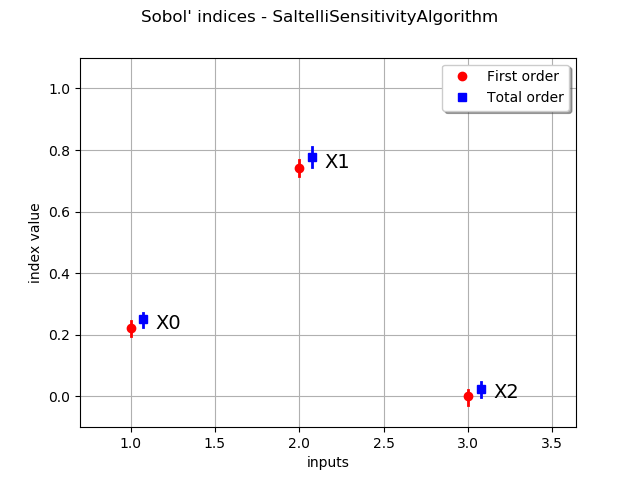

In [5]:
# Draw indices
sensitivityAnalysis.draw()

In [6]:
# second order indices
second_order = sensitivityAnalysis.getSecondOrderIndices()
for i in range(dimension):
    for j in range(i):
        print('2nd order indice %d,%d=%g' % (i,j,second_order[i,j]))

2nd order indice 1,0=-0.00818202
2nd order indice 2,0=7.41284e-05
2nd order indice 2,1=0.0107054
